In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

np.random.seed(1)

In [2]:
def initialize_params(layers_dimensions):
    """
    arguments:
        layer_dimensions -> python list, index i = layer i
    return:
        params -> python dict: ("Wl") = matrix; ("Bl") = vector
    """
    number_layers = len(layers_dimensions) # index 0 is the input layer
    params = {}
    for l in range(1, number_layers):
        n_input = layers_dimensions[l - 1]
        n_hidden = layers_dimensions[l]
        Wl = np.random.randn(n_hidden, n_input) * np.sqrt(2.0 / n_input)
        bl = np.zeros((n_hidden, 1))
        params["W" + str(l)] = Wl
        params["b" + str(l)] = bl

        # Making sure the dimensions are right
        assert(Wl.shape == (n_hidden, n_input))
        assert(bl.shape == (n_hidden, 1))

    return params

In [3]:
def forward_propagation(X, params, activation_functions):
    """
    arguments:
        X -> training examples: (n0, m)
        params -> python dict: ("Wl") = matrix; ("Bl") = vector
        activation_functions -> python list, index i = activation ith layer
    return:
        A -> output for the Lth layer
        caches -> will be used to compute backprogation: (linear_cache, Z) for index i
    """
    n_layers = len(params) // 2
    A = X
    caches = []

    # Making sure the input is of the correct size
    assert(n_layers == len(activation_functions))
    
    for l in range(n_layers):
        A_prev = A
        W = params["W" + str(l + 1)]
        b = params["b" + str(l + 1)]
        activation_function = activation_functions[l]
        A, cache = forward_propagation_single_layer(A_prev, W, b, activation_function)
        caches.append(cache)

    return A, caches

In [4]:
def forward_propagation_single_layer(A_prev, W, b, activation_function):
    """
    arguments:
        A_prev -> input from the previous layer
        W, b -> params of the current layer
        activivation_function -> activation function for the current layer ("sigmoid", "relu")
    return:
        A -> output from the current layer
        cache -> will be used to compute backpropagation: (linear_cache, Z)
    """
    Z, linear_cache = linear_function(A_prev, W, b)
    A = apply_activation_function(Z, activation_function)
    cache = (linear_cache, Z)
    return A, cache

In [5]:
def linear_function(A_prev, W, b):
    """
    arguments:
        A_prev -> input from the previous layer
        W, b -> params of the current layer
    return:
        z -> matrix of shape: (n_hidden_layers, n_training_examples)
        cache -> will be used to compute backpropagation: (A_prev, W, b)
    """
    Z = np.matmul(W, A_prev) + b
    cache = (A_prev, W, b)
    return Z, cache

In [6]:
def apply_activation_function(Z, activation_function):
    """
    arguments:
        Z -> linear output from the current layer
        activivation_function -> activation function for the current layer ("sigmoid", "relu")
    """
    if activation_function == "sigmoid":
        A = 1 / (1 + np.exp(np.clip(-Z, -30, 30)))
    elif activation_function == "relu":
        A = np.maximum(0, Z)
    elif activation_function == "tanh":
        A = np.tanh(Z)

    return A

In [7]:
def backward_propagation(AL, Y, activation_functions, caches, _lambda):
    """
    arguments:
        AL(Y_hat) -> output for the Lth layer
        Y -> true output from the dataset
        caches -> will be used to compute the gradients: (linear_cache, Z) for index i
    return:
        grads -> gradients for each layer parameter
    """
    grads = {}
    n_layers = len(caches)
    m = AL.shape[1]

    assert(len(activation_functions) == n_layers)
    assert(AL.shape == Y.shape)
    
    # Computing the gradients for the Lth layer to start out backward propagation
    cache = caches[n_layers - 1]
    linear_cache, Z = cache
    _, W, _ = linear_cache
    activation_function = activation_functions[n_layers - 1]
    
    dAL = - np.divide(Y, AL) + np.divide(1 - Y, 1 - AL)
    dA_prev, dW, db = backward_propagation_single_layer(dAL, cache, activation_function)
    dW += (_lambda / m) * W
    
    grads["dA" + str(n_layers - 1)] = dA_prev
    grads["dW" + str(n_layers)] = dW
    grads["db" + str(n_layers)] = db

    for l in reversed(range(n_layers - 1)):
        cache = caches[l]
        linear_cache, Z = cache
        _, W, _ = linear_cache
        activation_function = activation_functions[l]
        
        dA = grads["dA" + str(l + 1)]
        dA_prev, dW, db = backward_propagation_single_layer(dA, cache, activation_function)
        reg_term = (_lambda / m) * W
        dW += reg_term
        
        grads["dA" + str(l)] = dA_prev
        grads["dW" + str(l + 1)] = dW
        grads["db" + str(l + 1)] = db

    return grads

In [8]:
def backward_propagation_single_layer(dA, cache, activation_function):
    """
    arguments:
        dA -> derivative of the cost with respect to the activation output
        cache -> (linear_cache, Z)
        activation_function -> activation function for the current layer ("sigmoid", "relu")
    return:
        dA_prev, dW, db -> derivative of the cost with respect to the following
    """
    linear_cache, Z = cache
    dZ = activation_backward(dA, Z, activation_function)
    dA_prev, dW, db = linear_backward(dZ, linear_cache)
    return dA_prev, dW, db

In [9]:
def activation_backward(dA, Z, activation_function):
    """
    arguments:
        dA -> derivative of the cost function with respect to A(l)
        Z -> linear output of the current layer
        activivation_function -> activation function for the current layer ("sigmoid", "relu")
    return:
        dZ -> derivative of the cost function with respect to Z(l)
    """
    A = apply_activation_function(Z, activation_function)
    if activation_function == "sigmoid":
        dZ = dA * A * (1 - A)
    elif activation_function == "relu":
        dZ = np.array(dA, copy=True)
        dZ[Z <= 0] = 0
    elif activation_function == "tanh":
        dZ = dA * (1 - np.square(A))

    return dZ

In [10]:
def linear_backward(dZ, linear_cache):
    """
    arguments:
        dZ -> derivative of the cost function with respect do Z(l)
        linear_cache -> (A_prev, W, b)
    return:
        dA_prev, dW, db -> derivatives of the cost function with respect to each one
    """
    A_prev, W, b = linear_cache
    num_neurons_current_layer, num_examples = dZ.shape
    num_neurons_prev_layer = A_prev.shape[0]
    
    # Calculate the gradients
    dA_prev = np.matmul(W.T, dZ)
    dW = (1 / num_examples) * np.matmul(dZ, A_prev.T)
    db = (1 / num_examples) * np.sum(dZ, axis=1).reshape(-1, 1)

    # Making sure the dimensions are right
    assert(dA_prev.shape == (num_neurons_prev_layer, num_examples))
    assert(dW.shape == (num_neurons_current_layer, num_neurons_prev_layer))
    assert(db.shape == (num_neurons_current_layer, 1))

    return dA_prev, dW, db

In [11]:
def update_parameters(parameters, grads, learning_rate):
    params = parameters
    n_layers = len(parameters) // 2
    for l in range(1, n_layers + 1):
        params["W" + str(l)] -= learning_rate * grads["dW" + str(l)]
        params["b" + str(l)] -= learning_rate * grads["db" + str(l)]

    return params

In [12]:
def cost_function(Al, Y, params, _lambda):
    m = Y.shape[1]
    loss = Y * np.log(Al) + (1 - Y) * np.log(1 - Al)
    cost = (-1 / m) * np.sum(loss)

    # Compute regularization term
    L2_regularization_term = 0
    for key in params.keys():
        if 'W' in key:
            L2_regularization_term += np.sum(np.square(params[key]))

    cost += (_lambda / (2 * m)) * L2_regularization_term
    return cost

In [13]:
def gradient_descent(X, Y, layer_dimensions, activation_functions, number_iterations = 2500, learning_rate = 0.0075, _lambda=1):
    """
    arguments:
        X, Y -> training-set
        layer_dimensions -> python list: index i = layer_dimension ith layer
        activation_functions -> python list: index i = activation ith layer
        number_iterations -> how many times you want gradient descent to run
        learning_rate -> the amount you want the parameters to be affect by the gradient update
    return:
        params -> updated params after all iterations
        costs -> python list containing cost during training
    """
    params = initialize_params(layer_dimensions)
    costs = []
    for i in range(number_iterations + 1):
        Al, caches = forward_propagation(X, params, activation_functions)
        grads = backward_propagation(Al, Y, activation_functions, caches, _lambda)
        params = update_parameters(params, grads, learning_rate)
        cost = cost_function(Al, Y, params, _lambda)
        costs.append(cost)
        if (i % 100) == 0:
            print(f"Cost at iteration {i} is: {cost}")

    return params, costs

In [14]:
# Testing the model
def load_data():
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:])
    train_set_y_orig = np.array(train_dataset["train_set_y"][:])

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:])
    test_set_y_orig = np.array(test_dataset["test_set_y"][:])

    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig

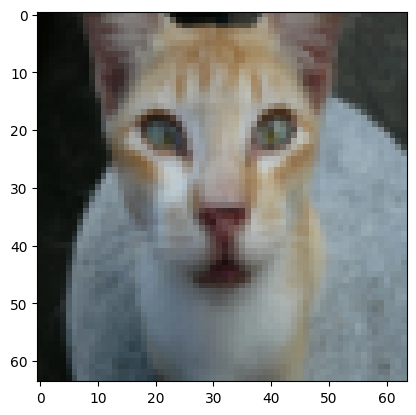

In [15]:
X_train, Y_train, X_test, Y_test = load_data()
plt.imshow(X_train[11])

In [16]:
X_train, X_test = X_train.reshape(X_train.shape[0], -1).T, X_test.reshape(X_test.shape[0], -1).T
X_train =  X_train / 255
X_test = X_test / 255
print("X train shape: ", X_train.shape)
print("Y train shape: ", Y_train.shape)
print("Number of training examples: ", X_train.shape[1])
print("Number of test examples: ", X_test.shape[1])

X train shape:  (12288, 209)
Y train shape:  (1, 209)
Number of training examples:  209
Number of test examples:  50


In [17]:
n_neurons_first_layer, n_training_examples = X_train.shape
n_neurons_output_layer = Y_train.shape[0]

# Neural network with 3 hidden layers
layer_dimensions = [n_neurons_first_layer, 20, 7, 5, n_neurons_output_layer]
params = initialize_params(layer_dimensions)
activation_functions = ["relu", "relu","tanh", "sigmoid"]

In [18]:
parameters, costs = gradient_descent(
    X_train, Y_train, layer_dimensions, activation_functions, number_iterations=4000, learning_rate = 0.004, _lambda=8.5
)

Cost at iteration 0 is: 2.2916028872863565
Cost at iteration 100 is: 2.002717202842195
Cost at iteration 200 is: 1.9271890535543799
Cost at iteration 300 is: 1.8282705469165852
Cost at iteration 400 is: 1.7543331125776302
Cost at iteration 500 is: 1.6791925609002667
Cost at iteration 600 is: 1.5901603582005719
Cost at iteration 700 is: 1.5290319008438458
Cost at iteration 800 is: 1.463253962794341
Cost at iteration 900 is: 1.4066816540224776
Cost at iteration 1000 is: 1.3547522518301691
Cost at iteration 1100 is: 1.308649123269155
Cost at iteration 1200 is: 1.2687137908608774
Cost at iteration 1300 is: 1.224577454095508
Cost at iteration 1400 is: 1.1854939582623483
Cost at iteration 1500 is: 1.1506723351090034
Cost at iteration 1600 is: 1.11760466221304
Cost at iteration 1700 is: 1.085447590775218
Cost at iteration 1800 is: 1.0561940847220415
Cost at iteration 1900 is: 1.0277346368170537
Cost at iteration 2000 is: 1.0008011910731316
Cost at iteration 2100 is: 0.9752530908122156
Cost at

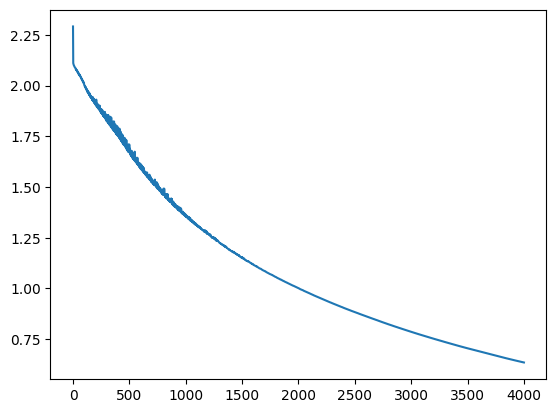

In [19]:
plt.plot(costs)

In [20]:
def get_percentage_correct_pred(AL, Y):
    n = Y.shape[1]
    AL_binary = [0] * n
    for i in range(n):
        if AL[0][i] > 0.5:
            AL_binary[i] = 1
        else:
            AL_binary[i] = 0
            
    correct_pred = np.equal(AL_binary, Y)
    correct = 0
    for i in range(n):
        correct += correct_pred[0][i]
    
    correct_percentage = (correct / n) * 100
    return correct_percentage

In [21]:
AL_train, caches = forward_propagation(X_train, parameters, activation_functions)
AL_test, caches = forward_propagation(X_test, parameters, activation_functions)
correct_train = get_percentage_correct_pred(AL_train, Y_train)
correct_test = get_percentage_correct_pred(AL_test, Y_test)
print("Percentage of correct predictions Training set: ", correct_train)
print("Percentage of correct predictions Test set", correct_test)

Percentage of correct predictions Training set:  100.0
Percentage of correct predictions Test set 76.0


## Conclusion
The model worked as expected, achieving a good accuracy on the traning set, although, since the dataset is very small, the model ended up overfitting to the training data, even then, the test set acurracy was still decent.